In [78]:
%load_ext autoreload
%autoreload 2
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from sklearn.linear_model import LinearRegression
import collections
import data_loader
pd.set_option('mode.chained_assignment','raise')
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'0.10'

# San Francisco

## Load data
Note that the number of segment IDs provided in the Uber<->OSM mapping is higher than the number of segment IDs actually found in the speeds data.

In [28]:
data = data_loader.load_data_for_city('san-francisco')

OSM MultiDiGraph has 32497 nodes, 90240 edges
OSM Graph has 32497 nodes, 49390 edges
Speeds has 5474129 rows, 214407 distinct segment IDs
Dropped 4456064/5474129 Uber speeds with hour not in 7-10
After processing, 89487 distinct OSM way IDs in the speeds dataset


## Incompleteness of Uber data

Edges are black if they are present it at least one hour in the speeds data. Red edges are in the OSM map, but not anywhere in the speeds data.

Out of 49390 total edges in the OSM graph, 20444 are in the Uber data


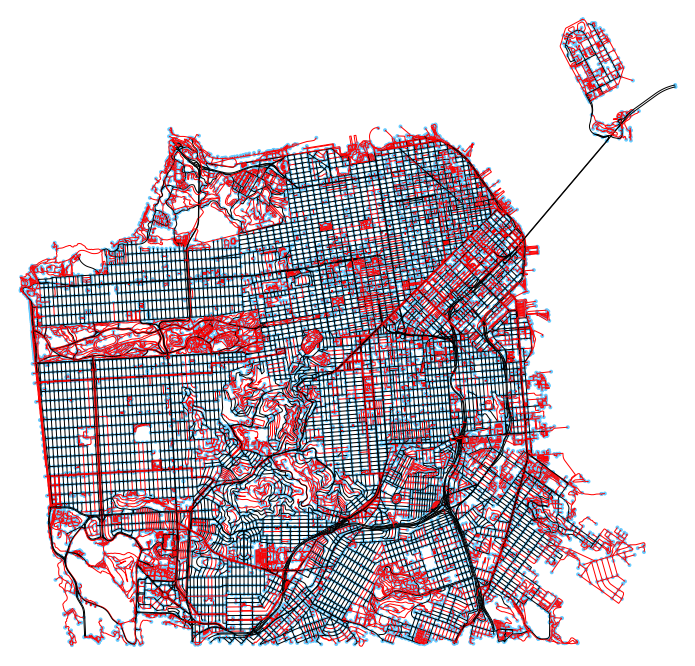

In [35]:
data_loader.plot_map_for_discrepancy(data)

## Merging the data

Only keep data that is common to both OSM and Uber datasets

In [38]:
data_loader.merge_uber_osm_data(data)

Dropped 0 vertices, 0 edges from graph
Dropped 0 Uber speeds not in OSM map


## Degree distribution

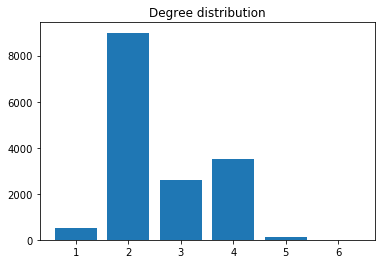

In [47]:
data_loader.plot_degree_distribution(data.graph)

## Plotting traffic

Edge color ranges from purple to green, indicating high to low traffic.

In [63]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, cmap='PiYG')
plt.axis('off');

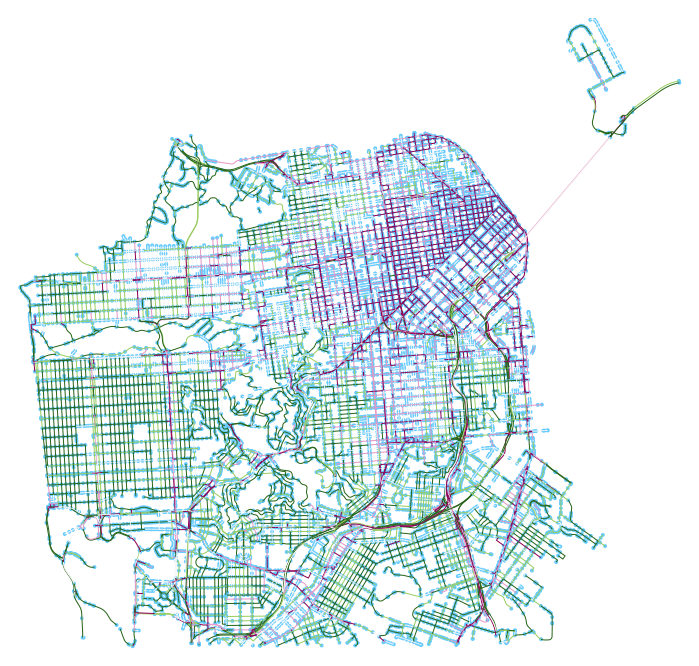

In [90]:
data_loader.plot_map_with_traffic(data.graph)

## Traffic prediction with linear regression

In [119]:
linear_data = data_loader.create_dataframe_for_baseline(data)

In [127]:
train_X = linear_data[['lanes', 'length', 'maxspeed']]
train_Y = linear_data['traffic']
model = LinearRegression()
model.fit(train_X, train_Y)
print('Training R^2 =', model.score(train_X, train_Y))
linear_data['traffic_predicted'] = model.predict(train_X)
print('Training sqrt(MSE) =', np.sqrt(((linear_data['traffic']-linear_data['traffic_predicted'])**2).mean()))

# Consider a segment to be "is_traffic" if it is above the median
linear_data['is_traffic'] = linear_data['traffic'] > linear_data['traffic'].median()
linear_data['is_traffic_predicted'] = linear_data['traffic_predicted'] > linear_data['traffic_predicted'].median()
print('Binary training accuracy of predicting traffic:',
    (linear_data['is_traffic_predicted'] == linear_data['is_traffic']).mean())

Training R^2 = 0.11605960935495994
Training sqrt(MSE) = 0.09003740728361362
Binary training accuracy of predicting traffic: 0.6444167186525265


In [128]:
linear_data

lanes      length  maxspeed   traffic  traffic_predicted  \
osm_way_id                                                             
7373728       1.0   97.634000      30.0  0.815352           0.786833   
7373736       1.0  133.903250      30.0  0.770939           0.792141   
7448875       1.0   73.260000      30.0  0.814209           0.783267   
8914965       1.0   59.543000      30.0  0.750807           0.781260   
8914974       1.0  135.044333      30.0  0.827367           0.792308   
...           ...         ...       ...       ...                ...   
694605192     2.0  271.509000      35.0  0.820223           0.792966   
694654073     1.0  119.224000      30.0  0.851541           0.789993   
694654074     2.0   69.363000      30.0  0.697033           0.755665   
694654075     2.0   97.287000      30.0  0.820451           0.759751   
694654076     2.0   47.721500      30.0  0.667501           0.752499   

            is_traffic  is_traffic_predicted  
osm_way_id                                    
7373728           True                  True  
7373736          False                  True  
7448875           True                  True  
8914965          False                  True  
8914974           True                  True  
...                ...                   ...  
694605192         True                  True  
694654073         True                  True  
694654074        False                 False  
694654075         True                 False  
694654076        False                 False  

[8015 rows x 7 columns]

### Map of predicted traffic

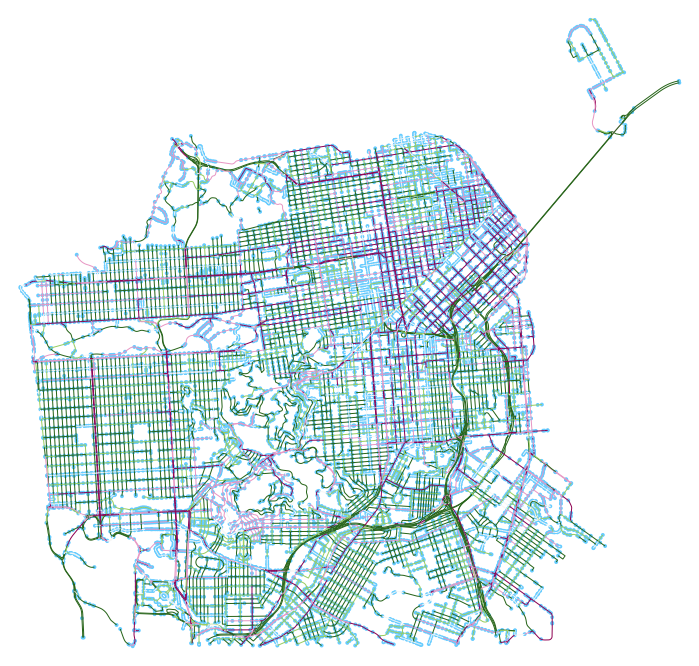

In [129]:
for v1, v2, edge in data.graph.edges(data=True):
    edge['traffic_predicted'] = linear_data.loc[edge['osmid'], 'traffic_predicted']
data_loader.plot_map_with_traffic(data.graph, 'traffic_predicted')

# Seattle

## Load data

In [130]:
data = data_loader.load_data_for_city('seattle')

OSM MultiDiGraph has 72456 nodes, 203918 edges
OSM Graph has 72456 nodes, 104853 edges
Speeds has 2010120 rows, 71993 distinct segment IDs
Dropped 1640449/2010120 Uber speeds with hour not in 7-10
After processing, 25322 distinct OSM way IDs in the speeds dataset


## Incompleteness of Uber data

Edges are black if they are present it at least one hour in the speeds data. Red edges are in the OSM map, but not anywhere in the speeds data.

Out of 104853 total edges in the OSM graph, 26670 are in the Uber data


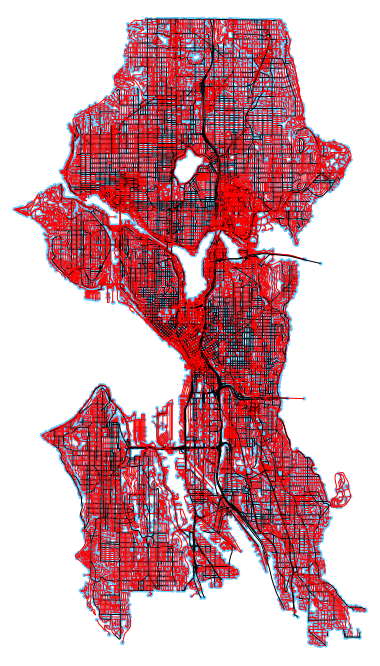

In [131]:
data_loader.plot_map_for_discrepancy(data)

## Merging the data

Only keep data that is common to both OSM and Uber datasets

In [132]:
data_loader.merge_uber_osm_data(data)

Dropped 48655 vertices, 78183 edges from graph
Dropped 18430 Uber speeds not in OSM map


## Degree distribution

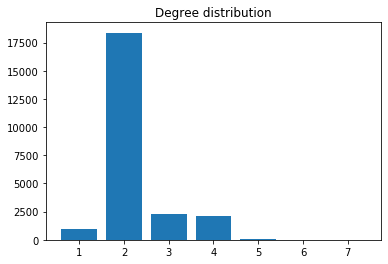

In [133]:
data_loader.plot_degree_distribution(data.graph)

## Plotting traffic

Edge color ranges from purple to green, indicating high to low traffic.

In [134]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, cmap='PiYG')
plt.axis('off');

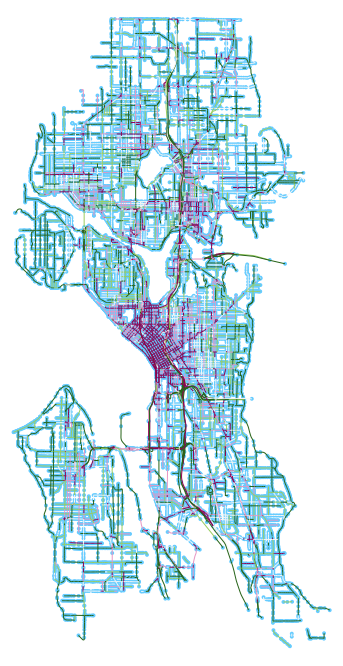

In [135]:
data_loader.plot_map_with_traffic(data.graph)

## Traffic prediction with linear regression (using model fit on San Francisco)

In [136]:
linear_data = data_loader.create_dataframe_for_baseline(data)

In [137]:
train_X = linear_data[['lanes', 'length', 'maxspeed']]
train_Y = linear_data['traffic']
print('Test R^2 =', model.score(train_X, train_Y))
linear_data['traffic_predicted'] = model.predict(train_X)
print('Test sqrt(MSE) =', np.sqrt(((linear_data['traffic']-linear_data['traffic_predicted'])**2).mean()))

# Consider a segment to be "is_traffic" if it is above the median
linear_data['is_traffic'] = linear_data['traffic'] > linear_data['traffic'].median()
linear_data['is_traffic_predicted'] = linear_data['traffic_predicted'] > linear_data['traffic_predicted'].median()
print('Binary test accuracy of predicting traffic:',
    (linear_data['is_traffic_predicted'] == linear_data['is_traffic']).mean())

Test R^2 = -0.19264215418474895
Test sqrt(MSE) = 0.09487579765076475
Binary test accuracy of predicting traffic: 0.6433546140452698


In [138]:
linear_data

lanes      length  maxspeed   traffic  traffic_predicted  \
osm_way_id                                                             
4634309       1.0  636.024000      60.0  0.846626           0.911940   
4636105       1.0  178.427500      30.0  0.875763           0.798656   
4636259       2.0   81.482000      30.0  0.731699           0.757439   
4637345       1.0  244.373000      30.0  0.837704           0.808305   
4637353       1.0  303.642000      30.0  0.751090           0.816978   
...           ...         ...       ...       ...                ...   
693449131     1.0   48.511500      35.0  0.853162           0.787366   
693449134     2.0    8.802667      20.0  0.739076           0.731362   
694281867     1.0   38.065500      30.0  0.834035           0.778117   
694281868     2.0   26.039000      30.0  0.574542           0.749326   
699193646     6.0   50.298000      35.0  0.741642           0.652472   

            is_traffic  is_traffic_predicted  
osm_way_id                                    
4634309           True                  True  
4636105           True                  True  
4636259          False                  True  
4637345           True                  True  
4637353          False                  True  
...                ...                   ...  
693449131         True                  True  
693449134        False                 False  
694281867         True                  True  
694281868        False                 False  
699193646        False                 False  

[6892 rows x 7 columns]

### Map of predicted traffic

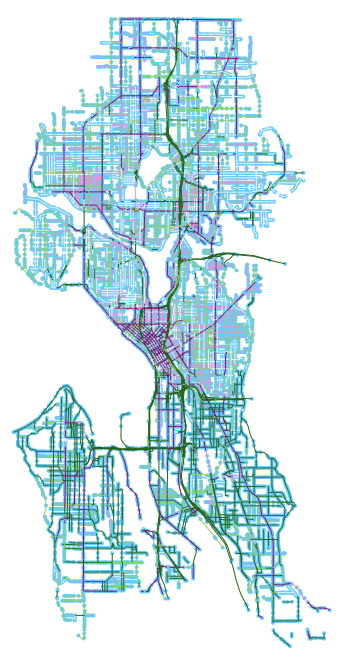

In [144]:
for v1, v2, edge in data.graph.edges(data=True):
    edge['traffic_predicted'] = linear_data.loc[edge['osmid'], 'traffic_predicted']
data_loader.plot_map_with_traffic(data.graph, 'traffic_predicted')

# New York

## Load data

In [145]:
data = data_loader.load_data_for_city('new-york')

OSM MultiDiGraph has 147128 nodes, 392615 edges
OSM Graph has 147128 nodes, 223911 edges
Speeds has 2607805 rows, 89249 distinct segment IDs
Dropped 2152247/2607805 Uber speeds with hour not in 7-10
After processing, 34996 distinct OSM way IDs in the speeds dataset


## Incompleteness of Uber data

Edges are black if they are present it at least one hour in the speeds data. Red edges are in the OSM map, but not anywhere in the speeds data.

Out of 223911 total edges in the OSM graph, 93400 are in the Uber data


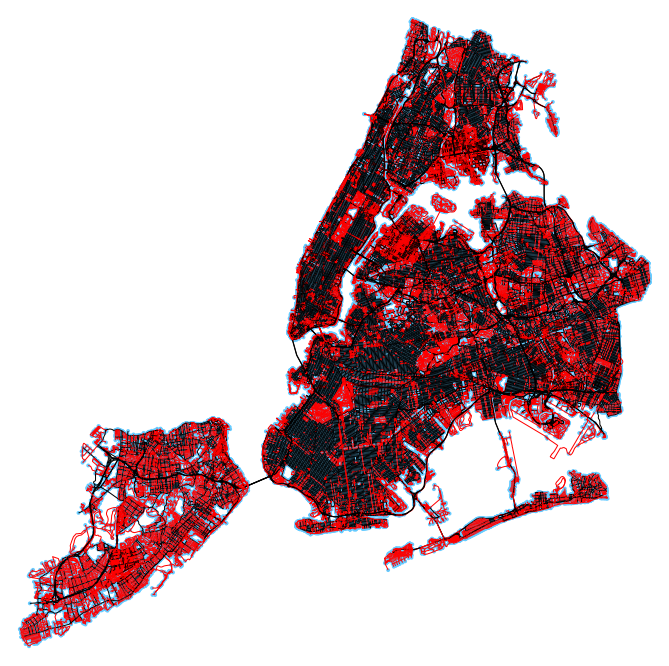

In [146]:
data_loader.plot_map_for_discrepancy(data)

## Merging the data

Only keep data that is common to both OSM and Uber datasets

In [147]:
data_loader.merge_uber_osm_data(data)

Dropped 77678 vertices, 130511 edges from graph
Dropped 5255 Uber speeds not in OSM map


## Degree distribution

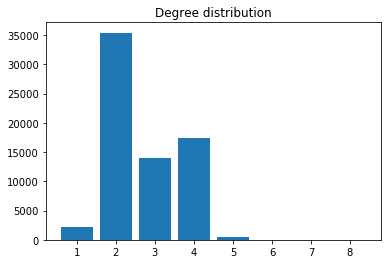

In [148]:
data_loader.plot_degree_distribution(data.graph)

## Plotting traffic

Edge color ranges from purple to green, indicating high to low traffic.

In [149]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, cmap='PiYG')
plt.axis('off');

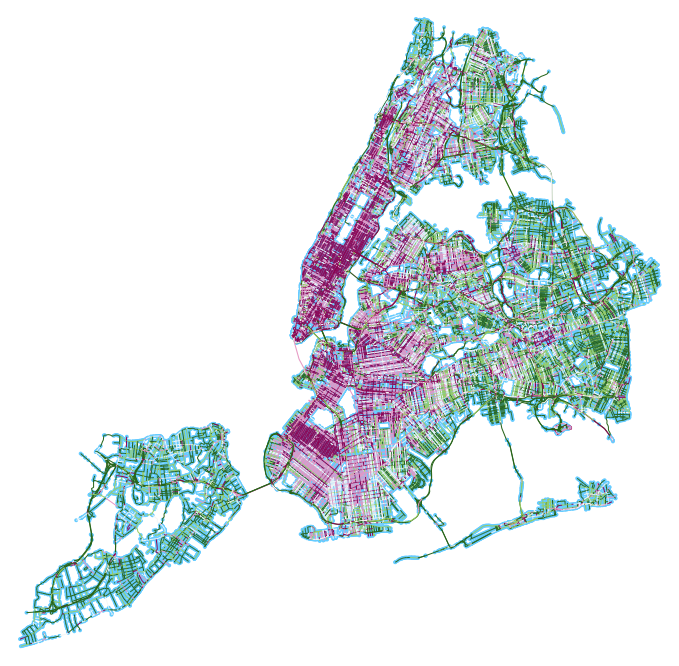

In [150]:
data_loader.plot_map_with_traffic(data.graph)

## Traffic prediction with linear regression (using model fit on San Francisco)

In [153]:
linear_data = data_loader.create_dataframe_for_baseline(data)

In [155]:
train_X = linear_data[['lanes', 'length', 'maxspeed']]
train_Y = linear_data['traffic']
print('Test R^2 =', model.score(train_X, train_Y))
linear_data['traffic_predicted'] = model.predict(train_X)
print('Test sqrt(MSE) =', np.sqrt(((linear_data['traffic']-linear_data['traffic_predicted'])**2).mean()))

# Consider a segment to be "is_traffic" if it is above the median
linear_data['is_traffic'] = linear_data['traffic'] > linear_data['traffic'].median()
linear_data['is_traffic_predicted'] = linear_data['traffic_predicted'] > linear_data['traffic_predicted'].median()
print('Binary test accuracy of predicting traffic:',
    (linear_data['is_traffic_predicted'] == linear_data['is_traffic']).mean())

Test R^2 = -0.09919789487569775
Test sqrt(MSE) = 0.09967840448473897
Binary test accuracy of predicting traffic: 0.5743922531185905


In [156]:
linear_data

lanes      length  maxspeed   traffic  traffic_predicted  \
osm_way_id                                                             
5029221       1.0   62.872000      30.0  0.570836           0.781747   
5668968       1.0  112.520833      30.0  0.675059           0.789012   
5668973       1.0   20.681000      30.0  0.719085           0.775573   
5668977       1.0  127.159500      30.0  0.641073           0.791154   
5668986       1.0   52.919714      30.0  0.728704           0.780290   
...           ...         ...       ...       ...                ...   
699686105     1.0   68.994000      30.0  0.606185           0.782643   
699686106     4.0  903.640000      30.0  0.783831           0.823681   
699924161     1.0   16.185000      30.0  0.682922           0.774915   
700407906     1.0  347.739000      30.0  0.802477           0.823431   
700407908     1.0   86.790000      30.0  0.802675           0.785247   

            is_traffic  is_traffic_predicted  
osm_way_id                                    
5029221          False                 False  
5668968          False                  True  
5668973          False                 False  
5668977          False                  True  
5668986          False                 False  
...                ...                   ...  
699686105        False                 False  
699686106         True                  True  
699924161        False                 False  
700407906         True                  True  
700407908         True                  True  

[29741 rows x 7 columns]

### Map of predicted traffic

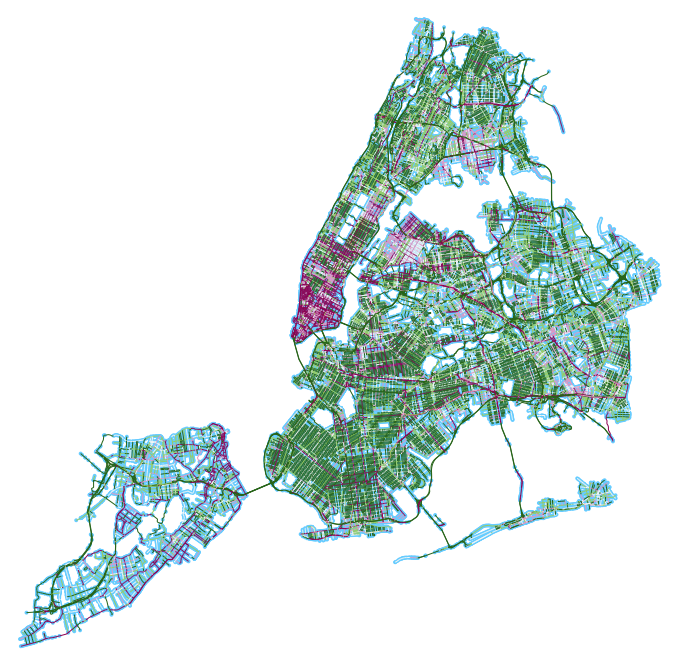

In [157]:
for v1, v2, edge in data.graph.edges(data=True):
    edge['traffic_predicted'] = linear_data.loc[edge['osmid'], 'traffic_predicted']
data_loader.plot_map_with_traffic(data.graph, 'traffic_predicted')